#  Global Annual Temperature Anomalies (degrees C) 1850-2015

For filtering (Kalman filter and fixed interval smoothing) I will use toolbok [E4](https://www.ucm.es/e-4/):

In [280]:
clear
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


It is also necessary to load the control toolbox

In [281]:
pkg load control

We load `gta.data` that I have download from [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

In [282]:
load gta.data

The fourteenth column of `gta` matrix contains the annual data for the years 1850--2015. For convenience I define the variable `y` with the annual data (i.e. periodicity one: `p=1`).

In [283]:
y = gta(:,14);
p = 1;

Professor Peter C. Young has kindly sent me the following data set. 

In [284]:
load data4Marcos.mat

The first column contains the same data (without the first 6 years).

In [285]:
size(Z)
size(y)

ans =

   160.00     2.00

ans =

   166.00     1.00



In [286]:
%plot gnuplot

In [287]:
plot([Z(:,1),y(7:end)])

... better if the figures are inserted in the notebook itself in 'png' format...

In [288]:
%plot --format png

I'll try to improve the graph

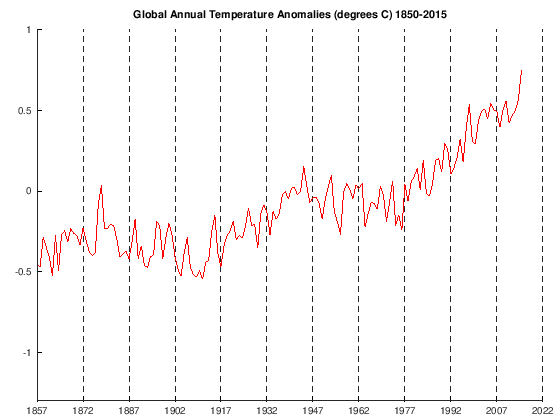

In [319]:
#dates = gta(:,1);
y=Z(:,1);
dates = gta(7:end,1);
yr = datenum (dates,1,1);
plot(yr, y, 'r')
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
ylim([-1.3, 1])
title('Global Annual Temperature Anomalies (degrees C) 1850-2015')
box off;

I will define a range of AR orders to work with. Since the data are annual, it is better to use long autoregressive orders to avoid identifying noisy trends (I want the pseudo-spectrum of the trend component to be close to a spectral peak very close to the vertical axis, and this is only possible if we use a high order autoregressive polynomial).

In [326]:
rgar = [52:70];

If we do not indicate an a priori model, and also the periodicity of the data is annual `(p=1)`, then the `LDHR` toolbox will try to fit (_whenever possible_) an IRW trend plus an irregular component model.

In [327]:
[VAR,P,TVP,oar]=autodhr(y,p,[],rgar)
NVR = VAR(2)/VAR(1)

VAR =

   0.00   0.00

P = Inf
TVP =

   1.00
   1.00

oar = 55.00
NVR = 0.00


`TVP` indicates two unit roots for a component with periodicity `P=Inf`, that is, an IRW trend. VAR contains the estimated variances, `oar` is the order of the AR polinomial used to identify and adjust the model.

Using this model, we filter the series (by Fixed-Interval Smoothing) to obtain the components

In [328]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,0,0);

Let's draw them (to make the figure clearer, I will move down the irregular component).

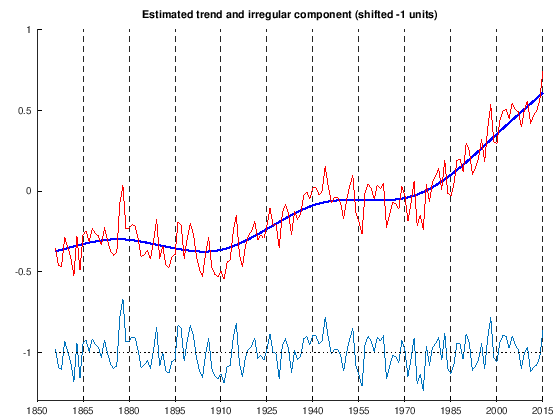

In [329]:
plot(yr, Trend, '-b', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated trend and irregular component (shifted -1 units)')
box off;

The trend shows a cyclical behaviour. We can fit an AR polynomial and observe the periodicity associated with the roots of higher modulus and lower frequencies; we then find a cycle of about 63 years.


	AR(54)

Número de retardos mayor que el 33% del tamaño de la muestra
    aresp at line 134 column 3

 	 RAICES 	    NORMA 		 PERIODOS 
raices_polinomio =

   -1.00    1.00    2.04
    1.00    1.00     Inf
    0.99    0.99   69.46
   -0.13    0.99    3.70
   -0.80    0.99    2.50
   -0.97    0.99    2.15
   -0.21    0.99    3.52
    0.36    0.99    5.23
    0.76    0.99    9.13
   -0.57    0.99    2.88
    0.94    0.99   21.08
   -0.69    0.98    2.67
   -0.37    0.98    3.21
    0.51    0.98    6.17
    1.02    1.02     Inf
    0.24    0.98    4.76
    0.97    0.98   50.11
    0.10    0.98    4.28
    0.66    0.98    7.62
    0.89    0.97   14.64
   -0.92    0.97    2.24
    0.81    0.97   10.92
   -0.87    0.96    2.32
   -0.42    0.96    3.10
    0.03    0.96    4.07
    0.55    0.93    6.67
   -0.75    0.91    2.48
    0.66    0.70   17.71



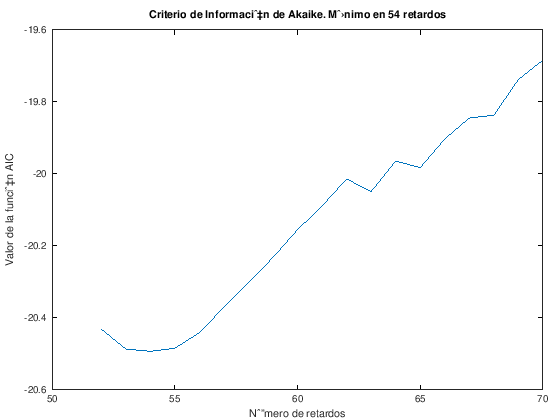

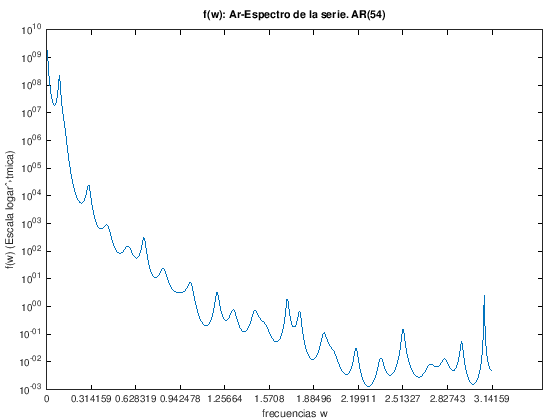

In [330]:
[ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp(Trend,rgar,0,2);

I will show the periodicities of the roots associated to lower frequencies and norms greater than 0.98.

In [331]:
[s,i]=sort(P,'descend');
format bank
n=20
R=[[1:n]',[P,NORM](i(1:n),:)];
R(R(:,3)>.97,:)

n = 20.00
ans =

    1.00     Inf    1.00
    2.00     Inf    1.02
    3.00   69.46    0.99
    4.00   50.11    0.98
    5.00   21.08    0.99
    7.00   14.64    0.97
    9.00    9.13    0.99
   10.00    7.62    0.98
   12.00    6.17    0.98
   13.00    5.23    0.99
   14.00    4.76    0.98
   15.00    4.28    0.98
   17.00    3.70    0.99
   18.00    3.52    0.99
   19.00    3.21    0.98



In [334]:
70./[0,1,3,7,12:20]

ans =

 Columns 1 through 10:

     Inf   70.00   23.33   10.00    5.83    5.38    5.00    4.67    4.38    4.12

 Columns 11 through 13:

    3.89    3.68    3.50



From this exploration of the data, it appears that there is a 63 year cycle and two harmonics of periodicities 21 and 9 years.

Hence, `PaP` will be the "_a priori_" periodicity of our DHR components model

In [374]:
PaP = 63./[0,1,3,7,12,17,19]
#PaP = 63./[0,1,3,7,12,17]
#PaP = 63./[0,1,3,7]
#PaP = 63./[0,1,3]   % try this if you don't want to consider the 9 years harmonic
format long

PaP =

 Columns 1 through 3:

                     Inf   6.300000000000000e+01   2.100000000000000e+01

 Columns 4 through 6:

   9.000000000000000e+00   5.250000000000000e+00   3.705882352941177e+00

 Column 7:

   3.315789473684211e+00



Let's try to identify and estimate the parameters of a DHR model 

I will only provide "_a priori_" periodicities `PaP`, the range `rgar` of AR polinomials to explore, the periodicity of the data, i.e. `p=1` (anual data), and the data itself `y`.

In [375]:
#[VAR,P,TVP,oar]=autodhr(y,1,[],rgar,PaP)
[VAR,P,TVP,oar]=autodhr(y,1,[],rgar,PaP,[1,1;1,0],1)
NVR = VAR(2:end)./VAR(1)

VAR =

 Columns 1 through 3:

   8.311989230111070e-03   1.340525727636564e-05   7.218754343993168e-04

 Columns 4 through 6:

   1.163173372594273e-06   5.132340309296794e-05   3.263196597139520e-06

 Columns 7 and 8:

   1.201662143792250e-05   2.272373055431203e-06

P =

 Columns 1 through 3:

                     Inf   6.300000000000000e+01   2.100000000000000e+01

 Columns 4 through 6:

   9.000000000000000e+00   5.250000000000000e+00   3.705882352941177e+00

 Column 7:

   3.315789473684211e+00

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 66
NVR =

 Columns 1 through 3:

   1.612761627241246e-03   8.684749395298130e-02   1.399392299956975e-04

 Columns 4 through 6:

   6.174623387027912e-03   3.925891271993280e-04   1.445697426362272e-03

 Column 7:

   2.733849855338225e-04



It seems to work! Using the roots of an AR polynomial of order 54, it identifies an IRW trend and three RW cyclic components.

Let's obtain the components by filtering the series:

In [376]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,0,0);

The trend is a matrix with three columns:
* the first is the _Trend-Cycle_
* the second is the _Long-Term-Trend_
* the third is the _Cycle_ made up of 63, 21 and 9 year sinusoids 

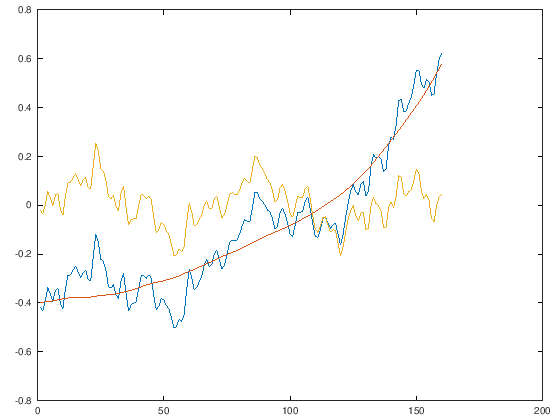

In [377]:
plot(Trend)

As can be seen in the following figure, the Trend-Cycle fits the evolution of the series quite well

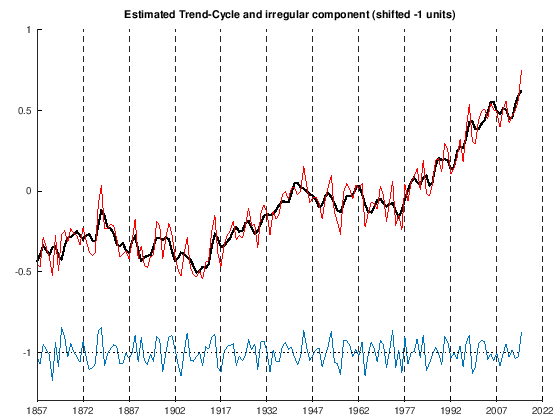

In [378]:
plot(yr, Trend(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated Trend-Cycle and irregular component (shifted -1 units)')
box off;

Although I think it is much more illustrative to plot the long-term Trend on the one hand, and the Cycle on the other.

it seems that the _Cycle_ apparently replicates the behaviour of the [Atlantic Multidecadal Oscillation (AMO)](https://www.psl.noaa.gov/data/timeseries/AMO/) (but I need AMO data to check).

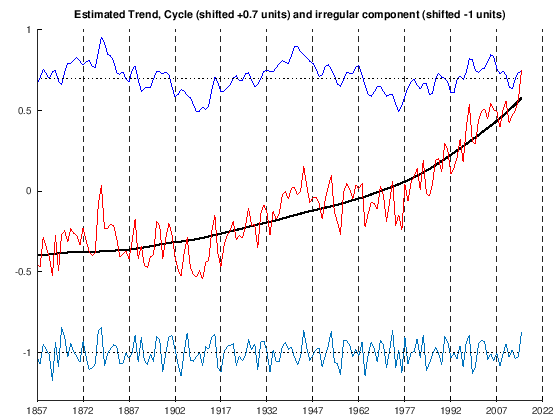

In [387]:
plot(yr, Trend(:,2), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
plot(yr, cycle+0.7, '-b')
plot(yr, ones(length(y))*.7, ':k')
ylim([-1.3, 1])
title('Estimated Trend, Cycle (shifted +0.7 units) and irregular component (shifted -1 units)')
box off;

In [380]:
load amo4Marcos.mat

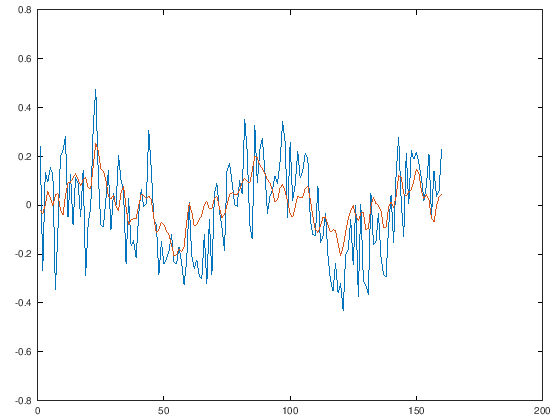

In [381]:
plot([amon,cycle])

In [382]:
[VAR,P,TVP,oar]=autodhr(amon,1,[],rgar,PaP(2:end),[1;0],1)

VAR =

 Columns 1 through 3:

   4.817357076570947e-02   4.237767358894397e-05   5.311868314071820e-05

 Columns 4 through 6:

   2.361335770053011e-06   2.975686175132255e-05   2.737782918505919e-05

 Column 7:

   8.154815136895799e-07

P =

 Columns 1 through 3:

   6.300000000000000e+01   2.100000000000000e+01   9.000000000000000e+00

 Columns 4 through 6:

   5.250000000000000e+00   3.705882352941177e+00   3.315789473684211e+00

TVP =

   1   1   1   1   1   1
   0   0   0   0   0   0

oar = 68


In [383]:
[TrendAMO,seasonAMO,cycleAMO,irregAMO]=dhrfilt(amon,P,TVP,VAR,12,0,0);

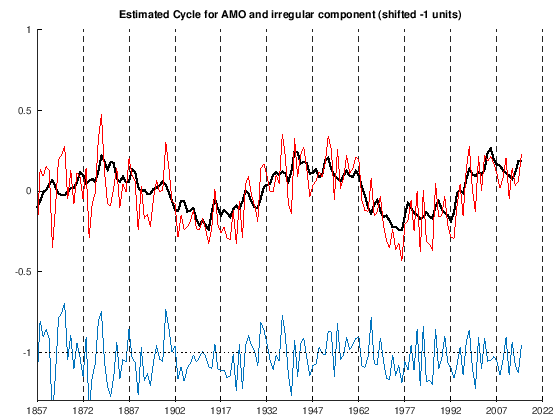

In [388]:
plot(yr, cycleAMO(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, amon,'-r')
plot(yr, irregAMO-1)
plot(yr, -ones(length(amon)), ':k')
ylim([-1.3, 1])
title('Estimated Cycle for AMO and irregular component (shifted -1 units)')
box off;

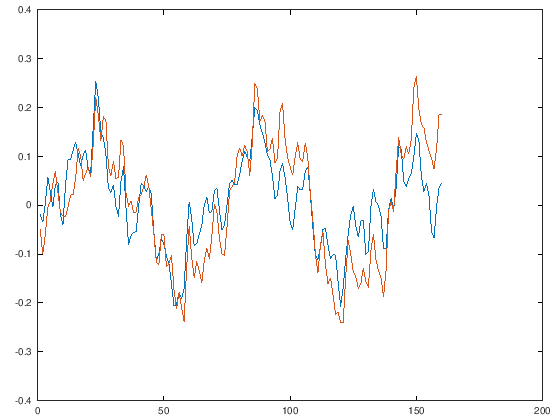

In [385]:
plot([cycle,cycleAMO])

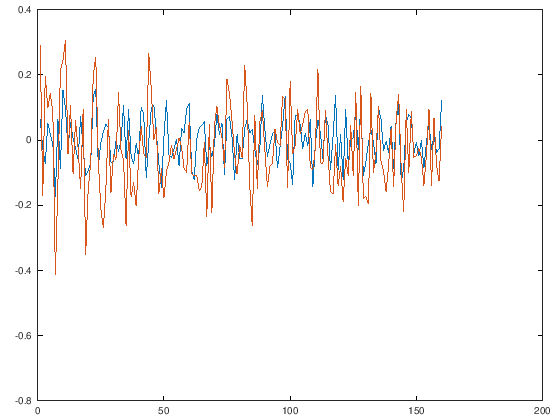

In [386]:
plot([irreg,irregAMO])